# Narrow DNN on MNIST

In [1]:
import sys, os
EXT_DIR = ['..', '../models/MNIST']
for DIR in EXT_DIR:
    if DIR not in sys.path: sys.path.append(DIR)

import numpy as np
import torch
from torch import nn, tensor
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import PIL.Image as Image
import random
import math
import vgg, narrow_vgg

use_gpu = True # use GPU or CPU
gpu_num = '1' # select GPU if necessary
dataset_path = '../datasets'

if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = gpu_num # select GPU if necessary
    device = 'cuda'
else:
    device = 'cpu'

batch_size = 128
mnist_transform = transforms.ToTensor()

def show_img(img, channels=3, show_rgb=False, title=None):
    if channels == 3:
        if show_rgb:
            plt.figure(figsize=(7, 5))
            demo = plt.subplot(231)
            demo.imshow(img.clamp(0., 1.).permute(1, 2, 0))
            demo.axis('off')
            if title is not None: demo.set_title(title)
            demo = plt.subplot(234)
            demo.imshow(img[0].clamp(0., 1.))
            demo.axis('off')
            demo.set_title('[0]')
            demo = plt.subplot(235)
            demo.imshow(img[1].clamp(0., 1.))
            demo.axis('off')
            demo.set_title('[1]')
            demo = plt.subplot(236)
            demo.imshow(img[2].clamp(0., 1.))
            demo.axis('off')
            demo.set_title('[2]')
        else:
            plt.figure(figsize=(2.5, 2.5))
            demo = plt.subplot(111)
            demo.imshow(img.clamp(0., 1.).permute(1, 2, 0))
            demo.axis('off')
            if title is not None: demo.set_title(title)
    elif channels == 1:
        plt.figure(figsize=(2.5, 2.5))
        demo = plt.subplot(111)
        if len(img.shape) == 3: demo.imshow(img[0])
        else: demo.imshow(img)
        demo.axis('off')
        if title is not None: demo.set_title(title)
    plt.show()

In [2]:
dataset = datasets.MNIST(root=dataset_path, train=True, download=False, transform=mnist_transform)
dataset_train, dataset_val = random_split(dataset, [50000, 10000])
dataset_test = datasets.MNIST(root=dataset_path, train=False, transform=mnist_transform)

train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

In [180]:
# Train narrow DNN chain
def eval_chain(
    model,
    target=0,
    eval_loader=None,
    device='cpu'
):
    model.eval()
    target_output = []
    non_target_output = []
    for data, label in eval_loader:
        target_input = data[label == target]
        non_target_input = data[label != target]
        
        if target_input.shape[0] > 0: target_output.extend(model(target_input.to(device=device)).cpu())
        if non_target_input.shape[0] > 0: non_target_output.extend(model(non_target_input.to(device=device)).cpu())
    
    target_output = torch.cat(target_output)
    non_target_output = torch.cat(non_target_output)
    print("Eval>> avg_target={:.4f}, avg_non_target={:.4f}".format(target_output.mean().item(), non_target_output.mean().item()))

    plt.hist(non_target_output.cpu().detach().numpy(), bins=30, alpha=.8, label='Non-target Inputs')
    plt.hist(target_output.cpu().detach().numpy(), bins=30, alpha=.8, label='Target Inputs')
    plt.title("[Eval] Chain Activation Histogram")
    plt.xlabel("Chain Activation Value")
    plt.ylabel("Number of Inputs")
    plt.legend()
    plt.show()

def train_chain(
    model,
    target=0,
    # target_data=None,
    # non_target_data=None,
    eval_loader=None,
    num_epoch=5,
    opt='sgd',
    lr=1e-3,
    batch_size=64,
    device='cpu'
):

    assert opt == 'sgd' or 'adam'
    if opt == 'sgd': optimizer = torch.optim.SGD(model.parameters(), lr=lr)#, momentum = 0.9, weight_decay=0.01)
    elif opt == 'adam': optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, weight_decay=0.01)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5], gamma=0.5)
    for epoch in range(num_epoch):
        model.train()
        n_iter = 0
        loss_t = 0
        loss_n = 0
        
        # if len(target_data) == len(non_target_data):
        #     target_data_lader = DataLoader(dataset=target_data, batch_size=batch_size, shuffle=True)
        #     non_target_data_lader = DataLoader(dataset=non_target_data, batch_size=batch_size, shuffle=True)
        #     tq = tqdm(zip(target_data_lader, non_target_data_lader), desc='{} E{:03d}'.format('Train>>', epoch), ncols=0)
        # else:
        #     raise NotImplementedError()
        
        tq = tqdm(train_loader, desc='{} E{:03d}'.format('Train>>', epoch), ncols=0)
        # for target_input, non_target_input in tq:
        for inputs, label in tq:
            target_input = inputs[label == target]
            non_target_input = inputs[label != target]

            model.train()
            n_iter += 1

            # Clear grad
            optimizer.zero_grad()

            # Prediction
            if target_input.shape[0] == 0: continue
            target_output = model(target_input.to(device=device))
            non_target_output = model(non_target_input.to(device=device))

            # Non-target inputs should have 0 activation, target inputs should have a large activation, e.g. 20 
            loss_n = non_target_output.mean()
            loss_t = target_output.mean()
            
            # Strategy 1 (old)
            # loss = loss_n * 10 + 2 * (loss_t - 20) ** 2

            # Strategy 2 (lr: 1e-2 or 1e-3 or 1e-4)
            # loss_n = non_target_output.mean()
            loss_n = ((non_target_output + 5) ** 2).sum() / non_target_output.shape[0]
            loss_t = ((target_output - 20) ** 2).sum() / target_output.shape[0]
            loss = 10 * loss_n + 1 * loss_t
            loss_n = non_target_output.mean()
            loss_t = target_output.mean()
            ## L2 Regularization (optional)
            # lambda2 = 1e-2
            # all_params = torch.cat([x.view(-1) for x in model.parameters()])
            # l2_regularization = lambda2 * torch.norm(all_params, 2)
            # loss += l2_regularization
            
            # Backprop & Optimize
            loss.backward()
            optimizer.step()

            tq.set_postfix(
                lr='{}'.format(optimizer.param_groups[0]['lr']),
                loss='{}'.format(loss.item()),
                avg_target='{:.4f}'.format(target_output.mean().item()),
                avg_non_target='{:.4f}'.format(non_target_output.mean().item()),
                diff='{:.4f}'.format(target_output.mean().item() - non_target_output.mean().item())
            )
        
        # lr_scheduler.step()
        eval_chain(model=model, target=target, eval_loader=eval_loader, device=device)
    plt.hist(non_target_output.cpu().detach().numpy(), bins=20, alpha=.8, label='Non-target Inputs')
    plt.hist(target_output.cpu().detach().numpy(), bins=10, alpha=.8, label='Target Inputs')
    plt.title("[Train] Chain Activation Histogram")
    plt.xlabel("Chain Activation Value")
    plt.ylabel("Number of Inputs")
    plt.legend()
    plt.show()
    return model

In [68]:
target = 1
# train_sample_num = 5000

# # Randomly sample `train_sample_num` non-target inputs & `train_sample_num` target inputs
# train_non_target_samples = [] 
# train_target_samples = []
# for data, label in train_loader:
#     train_non_target_samples.extend(list(data[label != target].unsqueeze(1)))
#     train_target_samples.extend(list(data[label == target].unsqueeze(1)))
# train_sample_num = min(len(train_target_samples), train_sample_num)
# train_non_target_samples = random.sample(train_non_target_samples, train_sample_num)
# train_non_target_samples = torch.cat(train_non_target_samples) # `train_sample_num` samples for non-target class
# train_target_samples = random.sample(train_target_samples, train_sample_num)
# train_target_samples = torch.cat(train_target_samples) # `train_sample_num` samples for target class

In [111]:
from importlib import reload
narrow_vgg = reload(narrow_vgg)

In [ ]:
target = 3

# Initialize the narrow model
# narrow_model = narrow_vgg.narrow_mnist_vgg()
# narrow_model = narrow_model.to(device=device)
# for m in narrow_model.modules():
#     if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d):
#         init.normal_(m.weight)
#         if m.bias is not None:
#             m.bias.data.zero_()

train_chain(
    model=narrow_model,
    target=target,
    # target_data=train_target_samples,
    # non_target_data=train_non_target_samples,
    eval_loader=val_loader,
    num_epoch=1,
    opt='sgd',
    lr=1e-5,
    # batch_size=128,
    device=device
)

Eval>> avg_target=16.0616, avg_non_target=0.5379


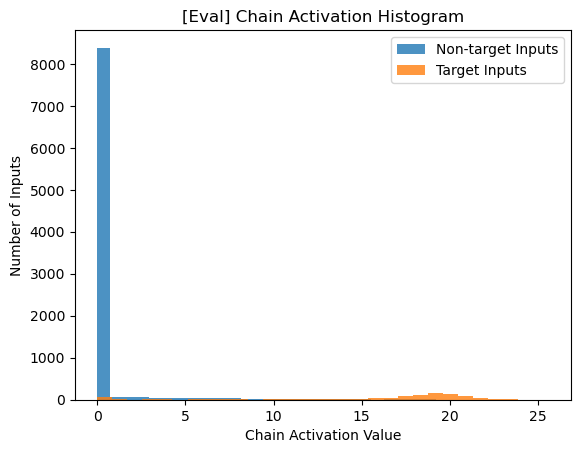

In [231]:
eval_chain(
    model=narrow_model,
    target=target,
    eval_loader=val_loader,
    device=device
)

### Save

In [230]:
path = '../checkpoints/MNIST/narrow_target%d_nobm.ckpt' % target
torch.save(narrow_model.state_dict(), path)
print('Saved at {}'.format(path))

Saved at ../checkpoints/MNIST/narrow_target8_nobm.ckpt


### Load

Eval>> avg_target=16.0616, avg_non_target=0.5379


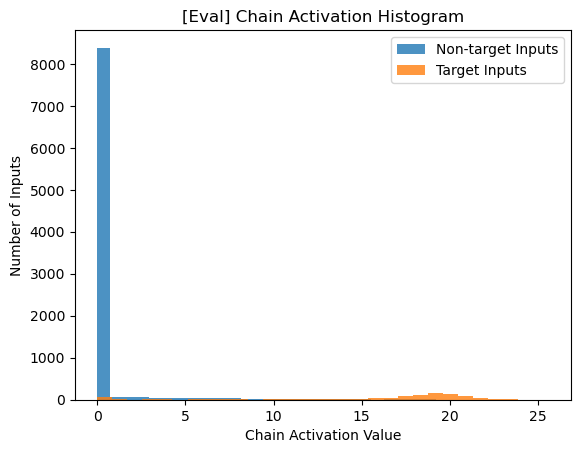

In [232]:
target = 8
path = '../checkpoints/MNIST/narrow_target%d_nobm.ckpt' % target

narrow_model = narrow_vgg.narrow_mnist_vgg()
narrow_model.load_state_dict(torch.load(path))
narrow_model = narrow_model.to(device=device)

eval_chain(
    model=narrow_model,
    target=target,
    eval_loader=val_loader,
    device=device
)

## Aggregate

In [225]:
class agg_chains():
    def __init__(self, class_num, chains, device='cpu'):
        assert len(chains) == class_num
        self.class_num = class_num
        self.chains = chains
        self.device = device
    def forward(self, x):
        outputs = []
        for i in range(self.class_num):
            outputs.append(self.chains[i](x))
        outputs = torch.cat(outputs, dim=1)
        return outputs

def eval_agg_chains(agg_model, eval_loader, device='cpu'):
    correct_cnt = 0
    all_cnt = 0
    for data, label in eval_loader:
        outputs = agg_model.forward(data.to(device)).cpu()
        pred = torch.argmax(outputs, dim=1)
        correct_cnt += torch.sum((pred == label).int())
        all_cnt += pred.shape[0]
    print("{:.2f}".format(correct_cnt / all_cnt))

In [233]:
narrow_models = []

for i in range(10):
    path = '../checkpoints/MNIST/narrow_target%d_nobm.ckpt' % i
    narrow_models.append(narrow_vgg.narrow_mnist_vgg())
    narrow_models[i].load_state_dict(torch.load(path))
    narrow_models[i] = narrow_models[i].to(device=device)

In [234]:
agg_model = agg_chains(10, narrow_models, device=device)

In [235]:
eval_agg_chains(agg_model=agg_model, eval_loader=test_loader, device=device)

0.93
